# Case Customer Segmentation

## Goal for this Notebook
- Melakukan clustering/segmentation pada dataset dan identifikasi kelompok customer populer
- Melakukan Location-wise analysis untuk identifikasi tren regional di Eropa
- Melakukan transaction-related analysis untuk identifikasi tren menarik yang dapat meningkatkan pengalaman penggunanya
- Pelanggan terkini, frekuensi, monetary analysis
- Network analysis atau graph analysis pada data customer

## Import Libraries

In [69]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
import seaborn as sns
try:
    import plotly.express as px
    import plotly.graph_objects as go
except:
    !pip install plotly
    import plotly.express as px
    import plotly.graph_objects as go
    
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

try:
    from kneed import KneeLocator
except:
    !pip install kneed
    from kneed import KneeLocator
    
try:
    from yellowbrick.cluster import KElbowVisualizer
except:
    !pip install -U yellowbrick
    from yellowbrick.cluster import KElbowVisualizer
    
try:
    import cv2 
except:
    !pip install opencv-python
    import cv2

## Data Collection

In [2]:
path= "/Users/Asus/Projects/Customer_Segmentation/CaseStudy/"

In [3]:
df_data=pd.read_csv(path+"CustomerDetails.csv")
df_data.head()

,CustomerID,DateOfBirth,Gender,City,AccountBalance,HavingFD,HavingCC,CIBIL_Score,HavingLoan,RV
0,C6532335,1990-04-01,M,ABHANPUR,25025.0,0,0,775,0,51384.0
1,C6232347,1990-04-01,M,ABHANPUR,25025.0,1,0,765,0,94271.0
2,C4284828,1994-05-13,F,ABOHAR,1985.0,0,0,373,0,83163.0
3,C8784892,1994-05-13,F,ABOHAR,1985.0,0,0,676,0,1985.0
4,C5416341,1991-12-04,F,ABOHAR,3.0,0,0,513,0,149484.0


In [36]:
branch_data=pd.read_csv(path+"BranchDetails.csv")
branch_data.head()

,City,BranchType
0,MUMBAI,Urban
1,BANGALORE,Urban
2,GURGAON,Urban
3,NOIDA,Urban
4,PUNE,Urban


In [37]:
df_data = df_data.merge(branch_data, on = 'City', how = 'left')
df_data.head()

,CustomerID,DateOfBirth,Gender,City,AccountBalance,HavingFD,HavingCC,CIBIL_Score,HavingLoan,RV,CustomerAge,BranchType
0,C6532335,1990-04-01,M,ABHANPUR,25025.0,0,0,775,0,51384.0,33,Rural
1,C6232347,1990-04-01,M,ABHANPUR,25025.0,1,0,765,0,94271.0,33,Rural
2,C4284828,1994-05-13,F,ABOHAR,1985.0,0,0,373,0,83163.0,29,Rural
3,C8784892,1994-05-13,F,ABOHAR,1985.0,0,0,676,0,1985.0,29,Rural
4,C5416341,1991-12-04,F,ABOHAR,3.0,0,0,513,0,149484.0,32,Rural


In [38]:
df_data.shape

(949016, 12)

## Data Cleaning

In [39]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 949016 entries, 0 to 949015
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   CustomerID      949016 non-null  object        
 1   DateOfBirth     949016 non-null  datetime64[ns]
 2   Gender          949016 non-null  object        
 3   City            949016 non-null  object        
 4   AccountBalance  949016 non-null  float64       
 5   HavingFD        949016 non-null  object        
 6   HavingCC        949016 non-null  object        
 7   CIBIL_Score     949016 non-null  int64         
 8   HavingLoan      949016 non-null  object        
 9   RV              949016 non-null  float64       
 10  CustomerAge     949016 non-null  int64         
 11  BranchType      948995 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(7)
memory usage: 94.1+ MB


In [40]:
#show detail dataset 
def check(data):
    l = []
    columns = data.columns
    for col in columns:
        dtypes = data[col].dtypes
        nunique = data[col].nunique()
        sum_null = data[col].isnull().sum()
        l.append([col, dtypes, nunique, sum_null])
    df_check = pd.DataFrame(l)
    df_check.columns = ['columns', 'dtypes', 'nunique', 'sum_null']
    return df_check
check(df_data)

,columns,dtypes,nunique,sum_null
0,CustomerID,object,813468,0
1,DateOfBirth,datetime64[ns],17081,0
2,Gender,object,2,0
3,City,object,3086,0
4,AccountBalance,float64,71084,0
5,HavingFD,object,2,0
6,HavingCC,object,2,0
7,CIBIL_Score,int64,600,0
8,HavingLoan,object,2,0
9,RV,float64,321052,0


In [41]:
#delete missing data
df_data.dropna(inplace=True)

In [42]:
#check duplicated data
df_data.duplicated().sum()

0

In [43]:
#convert type of columns DateOfBirth from object to datetime
df_data["DateOfBirth"]=pd.to_datetime(df_data["DateOfBirth"])

#### Calculate customer age:
- DateOfBirth is the birth date of the customer

In [44]:
this_year=2023
df_data["CustomerAge"] = this_year - df_data["DateOfBirth"].dt.year

In [45]:
# convert type of columns HavingFD, HavingCC, HavingLoan from integer to object
df_data["HavingFD"]=df_data["HavingFD"].astype(object)
df_data["HavingCC"]=df_data["HavingCC"].astype(object)
df_data["HavingLoan"]=df_data["HavingLoan"].astype(object)

In [46]:
num_col=df_data.select_dtypes(include=np.number)
cat_col=df_data.select_dtypes(exclude=np.number)

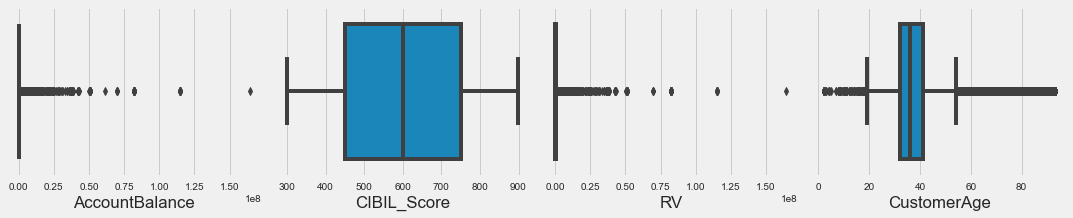

In [47]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(30,30))
for index, column in enumerate(num_col):
    plt.subplot(10,8,index+1)
    sns.boxplot(data=num_col,x=column)
    
plt.tight_layout(pad=1.0)

#### Observasi
- There is no outliers(I cant say that there is outliers, maybe some variables seem like outliers but they are not) => I decide spare any data.

In [48]:
#Creating Customer Table Strategy
Cust_data = df_data.groupby("CustomerID").agg({
    "Gender":"first",
    "City":"first",
    "AccountBalance":"mean",
    "HavingFD":"first",
    "HavingCC":"first",
    "CIBIL_Score":"mean",
    "HavingLoan":"first",
    "CustomerAge":"median",
    "BranchType":"first",
    "RV":"mean"
})

Cust_data = Cust_data.reset_index()
Cust_data.head()

,CustomerID,Gender,City,AccountBalance,HavingFD,HavingCC,CIBIL_Score,HavingLoan,CustomerAge,BranchType,RV
0,C1010011,M,DELHI,76341.0,1,0,346.5,1,35.5,Urban,177609.0
1,C1010012,M,MUMBAI,24204.0,1,1,482.0,1,29.0,Urban,204943.0
2,C1010014,F,MUMBAI,100113.0,1,0,802.0,0,35.0,Urban,237523.0
3,C1010018,F,CHAMPARAN,496.0,0,0,546.0,0,33.0,Rural,496.0
4,C1010024,M,KOLKATA,87059.0,1,1,728.0,0,58.0,Urban,244739.0


In [49]:
Cust_data.shape

(813454, 11)

In [50]:
Cust_data.drop(columns=["CustomerID"],inplace=True)

In [51]:
#Calculate the outliers for each feature
lower_list=[]
upper_list=[]
num_list=[]
perc_list=[]
cols=["AccountBalance", "CIBIL_Score", "CustomerAge", "RV"]
for i in cols:
    Q1 = Cust_data[i].quantile(0.25)
    Q3 = Cust_data[i].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    #calculate number of outliers
    num=Cust_data[(Cust_data[i] < lower) | (Cust_data[i] > upper)].shape[0]
    #calculate percentage of outliers
    perc = (num / Cust_data.shape[0]) * 100
    lower_list.append(lower)
    upper_list.append(upper)
    num_list.append(num)
    perc_list.append(round(perc,2))
    
    
dic={"lower":lower_list, "upper":upper_list, "outliers":num_list, "Perc%":perc_list}
outliers_data=pd.DataFrame(dic,index=["AccountBalance", "CIBIL_Score", "CustomerAge", "RV"])
outliers_data

,lower,upper,outliers,Perc%
AccountBalance,-73381.0625,136664.4375,106776,13.13
CIBIL_Score,45.5000,1153.5000,0,0.00
CustomerAge,18.5000,54.5000,40993,5.04
RV,-124672.5000,385577.5000,60391,7.42


May Some variables seem like outliers but they are not, I decided spare any data.

In [52]:
Cust_data.head()

,Gender,City,AccountBalance,HavingFD,HavingCC,CIBIL_Score,HavingLoan,CustomerAge,BranchType,RV
0,M,DELHI,76341.0,1,0,346.5,1,35.5,Urban,177609.0
1,M,MUMBAI,24204.0,1,1,482.0,1,29.0,Urban,204943.0
2,F,MUMBAI,100113.0,1,0,802.0,0,35.0,Urban,237523.0
3,F,CHAMPARAN,496.0,0,0,546.0,0,33.0,Rural,496.0
4,M,KOLKATA,87059.0,1,1,728.0,0,58.0,Urban,244739.0


## Exploratory Data Analysis

In [53]:
Cust_data.describe()

,AccountBalance,CIBIL_Score,CustomerAge,RV
count,8.134540e+05,813454.000000,813454.000000,8.134540e+05
mean,1.067545e+05,599.653056,38.048978,2.001947e+05
std,8.048473e+05,166.538167,8.402453,8.345461e+05
min,0.000000e+00,300.000000,2.000000,0.000000e+00
25%,5.386000e+03,461.000000,32.000000,6.667125e+04
50%,1.787000e+04,600.000000,36.000000,1.320230e+05
75%,5.789738e+04,738.000000,41.000000,1.942338e+05
max,1.644893e+08,899.000000,93.000000,1.646082e+08


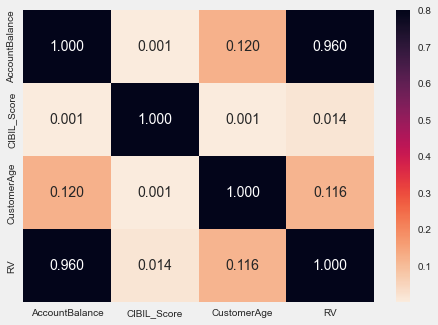

In [54]:
#correlation between features
plt.figure(figsize=(7,5))
correlation=Cust_data.corr()
sns.heatmap(correlation,vmin=None,
            vmax=0.8,
            cmap="rocket_r",
            annot=True,
            fmt=".3f",
            linecolor="white",
            cbar=True)
plt.show()

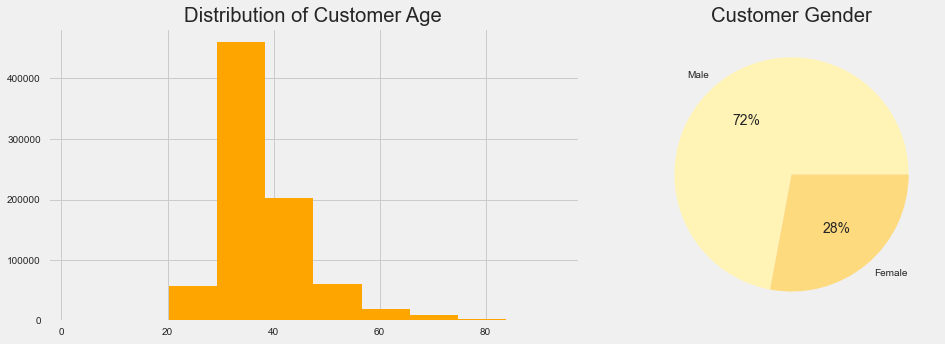

In [55]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,5))
palette_color=sns.color_palette("YlOrBr")
ax[0].hist(x=Cust_data["CustomerAge"],color="orange")
ax[0].set_title("Distribution of Customer Age")
ax[1].pie(Cust_data["Gender"].value_counts(),autopct="%1.f%%",
         colors=palette_color,labels=["Male","Female"])
ax[1].set_title("Customer Gender")
plt.tight_layout();
plt.show()

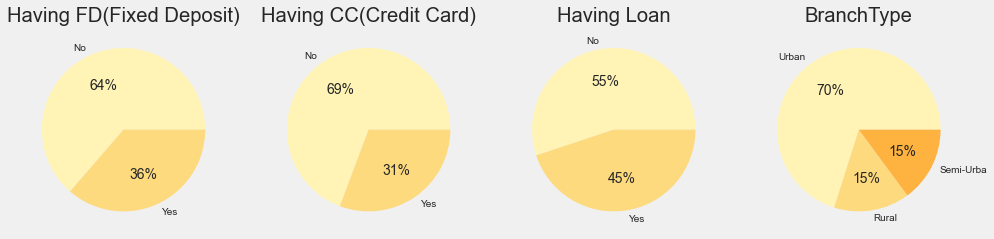

In [58]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(ncols=4,nrows=1,figsize=(15,10))
palette_color=sns.color_palette("YlOrBr")
ax[0].pie(Cust_data["HavingFD"].value_counts(),autopct="%1.f%%",
         colors=palette_color,labels=["No","Yes"])
ax[0].set_title("Having FD(Fixed Deposit)")
ax[1].pie(Cust_data["HavingCC"].value_counts(),autopct="%1.f%%",
         colors=palette_color,labels=["No","Yes"])
ax[1].set_title("Having CC(Credit Card)")
ax[2].pie(Cust_data["HavingLoan"].value_counts(),autopct="%1.f%%",
         colors=palette_color,labels=["No","Yes"])
ax[2].set_title("Having Loan")
ax[3].pie(Cust_data["BranchType"].value_counts(),autopct="%1.f%%",
         colors=palette_color,labels=["Urban","Rural","Semi-Urba"])
ax[3].set_title("BranchType")
plt.show()

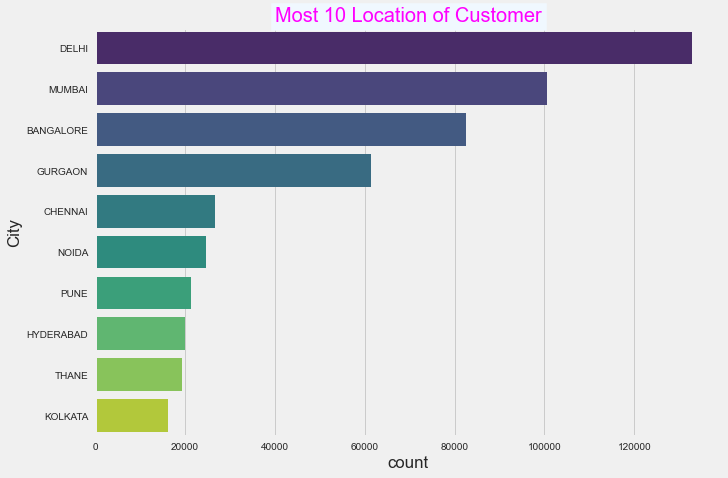

In [59]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(10,7))
chart=sns.countplot(y="City",data=Cust_data,palette="viridis",
                   order=Cust_data["City"].value_counts()[:10].index)
plt.title("Most 10 Location of Customer",
         fontsize="20",
         backgroundcolor="AliceBlue",
         color="magenta")
plt.show()

## Feature Engineering

In [60]:
Cust_data=Cust_data.reset_index(drop=True)

In [61]:
Cust_data.head()

,Gender,City,AccountBalance,HavingFD,HavingCC,CIBIL_Score,HavingLoan,CustomerAge,BranchType,RV
0,M,DELHI,76341.0,1,0,346.5,1,35.5,Urban,177609.0
1,M,MUMBAI,24204.0,1,1,482.0,1,29.0,Urban,204943.0
2,F,MUMBAI,100113.0,1,0,802.0,0,35.0,Urban,237523.0
3,F,CHAMPARAN,496.0,0,0,546.0,0,33.0,Rural,496.0
4,M,KOLKATA,87059.0,1,1,728.0,0,58.0,Urban,244739.0


In [62]:
Cust_data.drop(columns=["City"],inplace=True)

In [63]:
Cust_data["Gender"]=Cust_data["Gender"].map({"M":1,"F":0})
Cust_data["BranchType"]=Cust_data["BranchType"].map({"Urban":2,"Rural":1,"Semi-Urba":0})

In [64]:
#data scaling
df_scaled=StandardScaler().fit_transform(Cust_data)
df_scaled=pd.DataFrame(df_scaled,columns=Cust_data.columns)
print(df_scaled.shape)
df_scaled.head()

(813454, 9)


,Gender,AccountBalance,HavingFD,HavingCC,CIBIL_Score,HavingLoan,CustomerAge,BranchType,RV
0,0.622670,-0.037788,1.323123,-0.666102,-1.520091,1.107890,-0.303361,0.606457,-0.027063
1,0.622670,-0.102567,1.323123,1.501271,-0.706463,1.107890,-1.076945,0.606457,0.005690
2,-1.605987,-0.008252,1.323123,-0.666102,1.215019,-0.902617,-0.362868,0.606457,0.044729
3,-1.605987,-0.132023,-0.755787,-0.666102,-0.322167,-0.902617,-0.600894,-0.748042,-0.239290
4,0.622670,-0.024471,1.323123,1.501271,0.770676,-0.902617,2.374430,0.606457,0.053376


the data is very big so I will use only 100000 rows

In [65]:
df_scaled=df_scaled.sample(n=100000,random_state=42).reset_index(drop=True)
df_scaled.head()

,Gender,AccountBalance,HavingFD,HavingCC,CIBIL_Score,HavingLoan,CustomerAge,BranchType,RV
0,0.622670,-0.108230,-0.755787,-0.666102,1.605320,1.107890,1.660352,0.606457,-0.189889
1,0.622670,-0.126591,-0.755787,-0.666102,-0.718473,1.107890,-0.600894,-2.102541,-0.214678
2,0.622670,-0.053338,1.323123,1.501271,-1.000690,-0.902617,1.541339,0.606457,-0.089801
3,-1.605987,0.369800,1.323123,-0.666102,-0.172051,-0.902617,-0.124842,0.606457,0.480358
4,0.622670,-0.059544,1.323123,1.501271,0.644579,-0.902617,0.113184,0.606457,-0.057672


In [70]:
#data normalization
df_normalized=MinMaxScaler().fit_transform(Cust_data)
df_normalized=pd.DataFrame(df_normalized,columns=Cust_data.columns)
print(df_normalized.shape)
df_normalized.head()

(813454, 9)


,Gender,AccountBalance,HavingFD,HavingCC,CIBIL_Score,HavingLoan,CustomerAge,BranchType,RV
0,1.0,0.000464,1.0,0.0,0.077629,1.0,0.368132,1.0,0.001079
1,1.0,0.000147,1.0,1.0,0.303840,1.0,0.296703,1.0,0.001245
2,0.0,0.000609,1.0,0.0,0.838063,0.0,0.362637,1.0,0.001443
3,0.0,0.000003,0.0,0.0,0.410684,0.0,0.340659,0.5,0.000003
4,1.0,0.000529,1.0,1.0,0.714524,0.0,0.615385,1.0,0.001487


In [71]:
df_normalized=df_normalized.sample(n=100000,random_state=42).reset_index(drop=True)
df_normalized.head()

,Gender,AccountBalance,HavingFD,HavingCC,CIBIL_Score,HavingLoan,CustomerAge,BranchType,RV
0,1.0,0.000119,0.0,0.0,0.946578,1.0,0.549451,1.0,0.000253
1,1.0,0.000030,0.0,0.0,0.300501,1.0,0.340659,0.0,0.000128
2,1.0,0.000388,1.0,1.0,0.222037,0.0,0.538462,1.0,0.000761
3,0.0,0.002458,1.0,0.0,0.452421,0.0,0.384615,1.0,0.003652
4,1.0,0.000358,1.0,1.0,0.679466,0.0,0.406593,1.0,0.000924


## Modelling

#### K-mean
The **k-means** clustering is a method of vector quantization, originally from signal processing, that

The **Elbow** method is a graphical representation of finding the optimal 'K' in a K-means cluster

The **Silhouette Coefficient** or silhouette score is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1. 1: Means clusters are well apart from each other and clearly distinguished

The **Dendrogram** is a diagram that shows the hierarchical relationship between objects. It is most commonly created as an output from hierarchical clustering

In [72]:
#Kmeans algorithm settings
kmeans_set={"init":"random",
           "max_iter":300,
           "random_state":42}

inertias = []
silhouette_coefficients = []

for k in range(2,11):
    kmeans=KMeans(n_clusters=k, **kmeans_set) #open dictionary
    kmeans.fit(df_scaled)
    inertias.append(kmeans.inertia_)
    score=silhouette_score(df_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

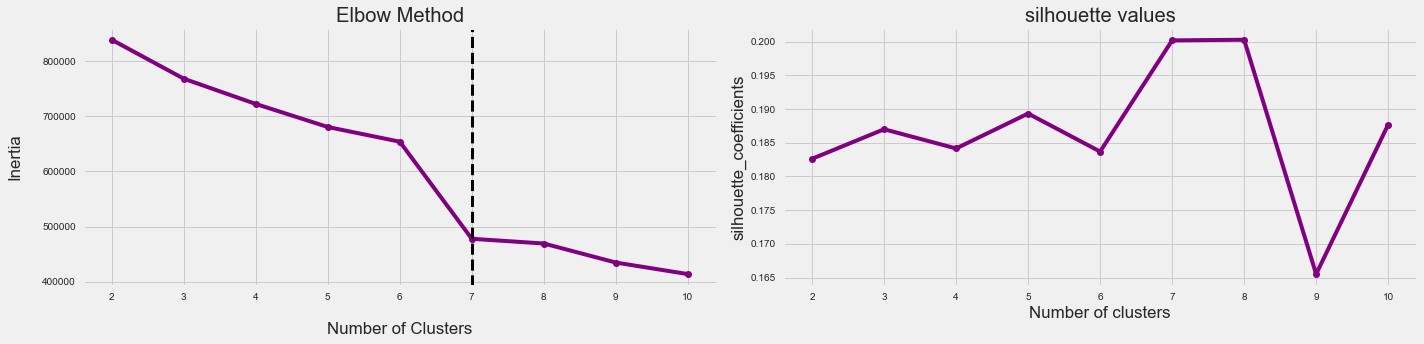

In [74]:
plt.style.use("fivethirtyeight")
fig, ax=plt.subplots(1,2,figsize=(20,5))
kl = KneeLocator(range(2,11),inertias,curve="convex",direction="decreasing")
ax[0].plot(range(2,11),inertias,color="purple",marker="o",label="Elbow Method")
ax[0].set_xticks(range(2,11))
ax[0].set_xlabel("Number of Clusters", labelpad=20)
ax[0].set_ylabel("Inertia", labelpad=20)
ax[0].set_title("Elbow Method")
ax[0].axvline(x=kl.elbow, color="black",label="axvline-fullheight", ls="--", linewidth=3)

ax[1].plot(range(2,11),silhouette_coefficients,color="purple",marker="o",label="silhouette coefficients")
ax[1].set_xticks(range(2,11))
ax[1].set_title("silhouette values")
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("silhouette_coefficients")
plt.tight_layout();
plt.show()

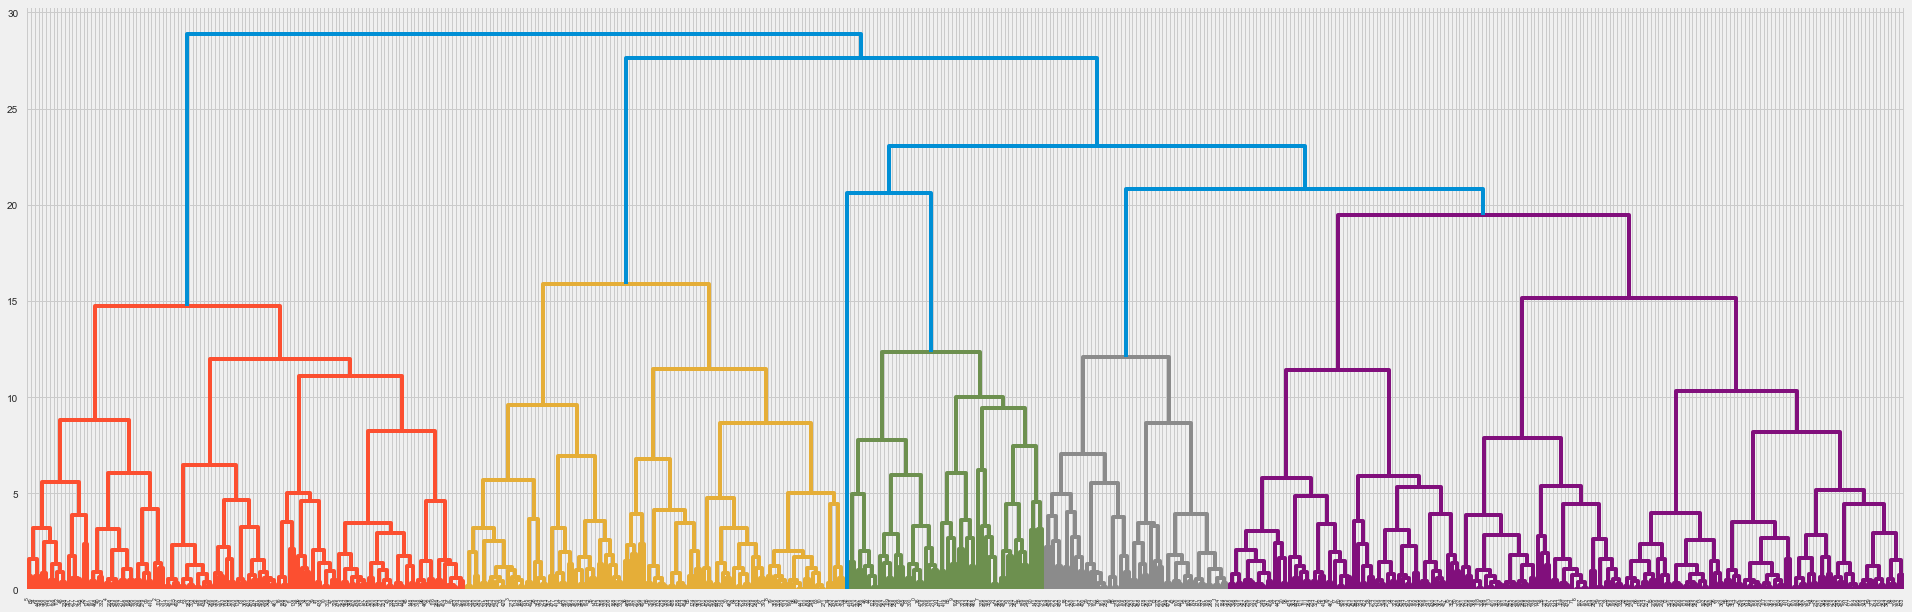

In [73]:
plt.figure(figsize=(30,10))
z=sch.linkage(df_scaled.iloc[:500,:],"ward")
sch.dendrogram(z);

the three charts insure that the number of clustering is 7 so I will use it

In [75]:
kmeans = KMeans(n_clusters=7, **kmeans_set)
kmeans.fit(df_scaled)
df_scaled["Label"]=kmeans.labels_
df_scaled.head()

,Gender,AccountBalance,HavingFD,HavingCC,CIBIL_Score,HavingLoan,CustomerAge,BranchType,RV,Label
0,0.622670,-0.108230,-0.755787,-0.666102,1.605320,1.107890,1.660352,0.606457,-0.189889,4
1,0.622670,-0.126591,-0.755787,-0.666102,-0.718473,1.107890,-0.600894,-2.102541,-0.214678,4
2,0.622670,-0.053338,1.323123,1.501271,-1.000690,-0.902617,1.541339,0.606457,-0.089801,3
3,-1.605987,0.369800,1.323123,-0.666102,-0.172051,-0.902617,-0.124842,0.606457,0.480358,5
4,0.622670,-0.059544,1.323123,1.501271,0.644579,-0.902617,0.113184,0.606457,-0.057672,3


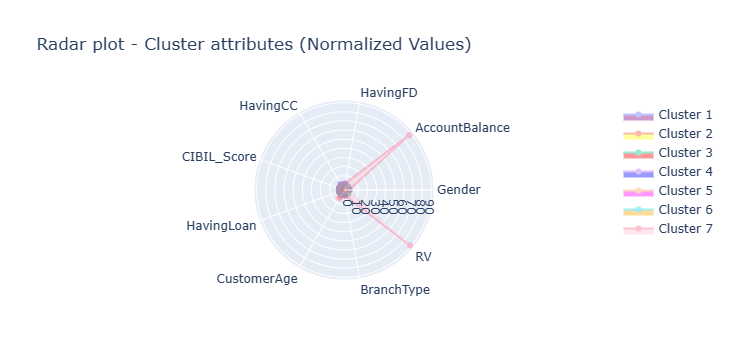

In [79]:
attributes=df_scaled.columns[:9]
colors=["purple","yellow","red","blue","magenta","orange","pink"]
cluster=["Cluster 1","Cluster 2","Cluster 3","Cluster 4","Cluster 5","Cluster 6","Cluster 7"]

fig = go.Figure()
for index in range(0,7):
    fig.add_trace(go.Scatterpolar(r=np.mean(df_scaled.loc[df_scaled.Label == index, attributes]),
                                 theta=attributes,
                                 fill="toself",
                                 fillcolor=colors[index],
                                 opacity=0.4,
                                 name=cluster[index]))
fig.update_layout(polar=dict(radialaxis=dict(visible=True)),
                 showlegend=True,
                 title="Radar plot - Cluster attributes (Normalized Values)")
fig.show()    

In [80]:
#Kmeans algorithm settings
kmeans_set={"init":"random",
           "max_iter":300,
           "random_state":42}

inertias = []
silhouette_coefficients = []

for k in range(2,11):
    kmeans=KMeans(n_clusters=k, **kmeans_set) #open dictionary
    kmeans.fit(df_normalized)
    inertias.append(kmeans.inertia_)
    score=silhouette_score(df_normalized, kmeans.labels_)
    silhouette_coefficients.append(score)

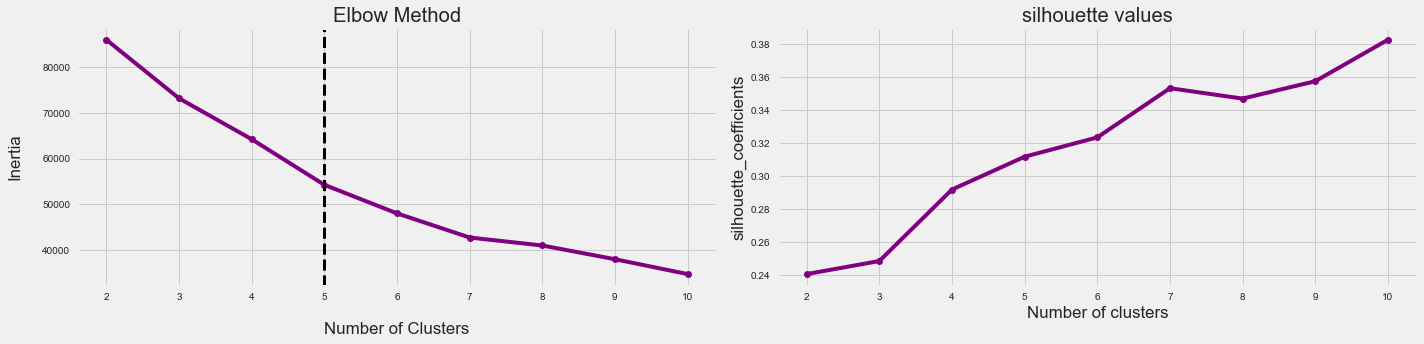

In [81]:
plt.style.use("fivethirtyeight")
fig, ax=plt.subplots(1,2,figsize=(20,5))
kl = KneeLocator(range(2,11),inertias,curve="convex",direction="decreasing")
ax[0].plot(range(2,11),inertias,color="purple",marker="o",label="Elbow Method")
ax[0].set_xticks(range(2,11))
ax[0].set_xlabel("Number of Clusters", labelpad=20)
ax[0].set_ylabel("Inertia", labelpad=20)
ax[0].set_title("Elbow Method")
ax[0].axvline(x=kl.elbow, color="black",label="axvline-fullheight", ls="--", linewidth=3)

ax[1].plot(range(2,11),silhouette_coefficients,color="purple",marker="o",label="silhouette coefficients")
ax[1].set_xticks(range(2,11))
ax[1].set_title("silhouette values")
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("silhouette_coefficients")
plt.tight_layout();
plt.show()

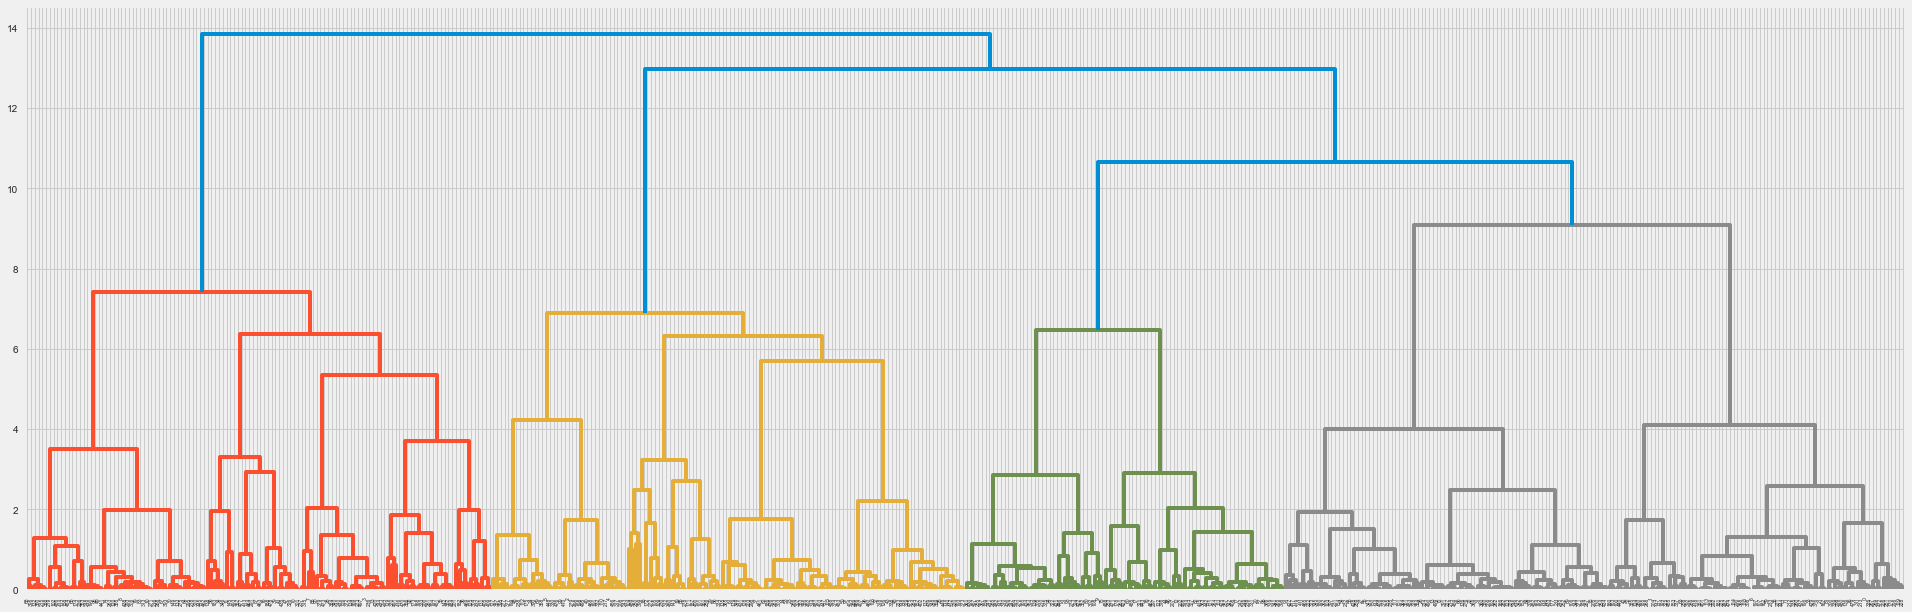

In [82]:
plt.figure(figsize=(30,10))
z=sch.linkage(df_normalized.iloc[:500,:],"ward")
sch.dendrogram(z);

In [85]:
kmeans = KMeans(n_clusters=5, **kmeans_set)
kmeans.fit(df_normalized)
df_normalized["Label"]=kmeans.labels_
df_normalized.head()

,Gender,AccountBalance,HavingFD,HavingCC,CIBIL_Score,HavingLoan,CustomerAge,BranchType,RV,Label
0,1.0,0.000119,0.0,0.0,0.946578,1.0,0.549451,1.0,0.000253,4
1,1.0,0.000030,0.0,0.0,0.300501,1.0,0.340659,0.0,0.000128,4
2,1.0,0.000388,1.0,1.0,0.222037,0.0,0.538462,1.0,0.000761,2
3,0.0,0.002458,1.0,0.0,0.452421,0.0,0.384615,1.0,0.003652,1
4,1.0,0.000358,1.0,1.0,0.679466,0.0,0.406593,1.0,0.000924,2


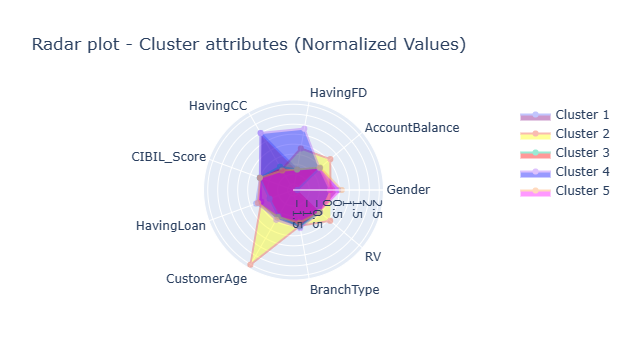

In [86]:
attributes=df_scaled.columns[:9]
colors=["purple","yellow","red","blue","magenta"]
cluster=["Cluster 1","Cluster 2","Cluster 3","Cluster 4","Cluster 5",]

fig = go.Figure()
for index in range(0,5):
    fig.add_trace(go.Scatterpolar(r=np.mean(df_scaled.loc[df_scaled.Label == index, attributes]),
                                 theta=attributes,
                                 fill="toself",
                                 fillcolor=colors[index],
                                 opacity=0.4,
                                 name=cluster[index]))
fig.update_layout(polar=dict(radialaxis=dict(visible=True)),
                 showlegend=True,
                 title="Radar plot - Cluster attributes (Normalized Values)")
fig.show()    

### PCA

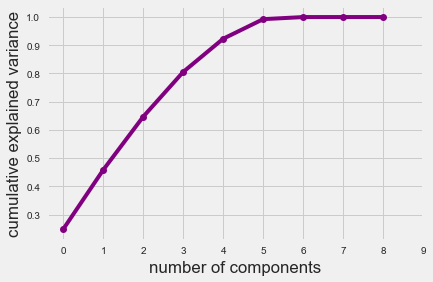

In [87]:
#here we want to check how many component we need to explain 90% of the variance
plt.style.use("fivethirtyeight")
pca = PCA().fit(df_normalized.iloc[:,:-1])
plt.plot(np.cumsum(pca.explained_variance_ratio_),color="purple",
        marker="o") #EX: cusum([4,2,3,1,6])==>[4,6,9,10,16]
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance")
#x tickes
plt.xticks(np.arange(0,10,1))
plt.show()

In [88]:
pca = PCA(n_components=4)
pca_data = pca.fit_transform(df_normalized.iloc[:,:-1])

inertia = []
silhouette = []

for k in range(2,11):
    km = KMeans(init="k-means++", n_clusters=k, random_state=42)
    km.fit(pca_data)
    inertia.append(km.inertia_)
    P_score=silhouette_score(pca_data, km.labels_)
    silhouette.append(P_score)

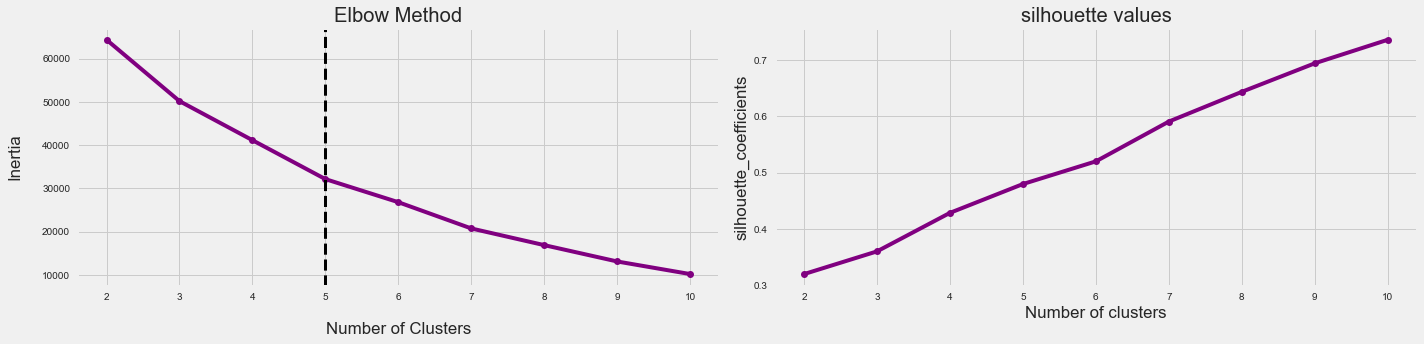

In [89]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(1,2, figsize=(20,5))
Pkl = KneeLocator(range(2,11), inertia, curve="convex", direction="decreasing")
#draw Elbow
ax[0].plot(range(2,11), inertia, color="purple",marker='o',label="Elbow Method")
ax[0].set_xticks(range(2,11))
ax[0].set_xlabel("Number of Clusters", labelpad=20)
ax[0].set_ylabel("Inertia", labelpad=20)
ax[0].set_title("Elbow Method")
ax[0].axvline(x=Pkl.elbow, color="black", label="axvline-fullheight",
             ls="--", linewidth=3)
#draw Silhouette
ax[1].plot(range(2,11), silhouette, color="purple",marker="o",
          label="silhouette coefficients")
ax[1].set_xticks(range(2,11))
ax[1].set_title("silhouette values")
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("silhouette_coefficients")
plt.tight_layout();

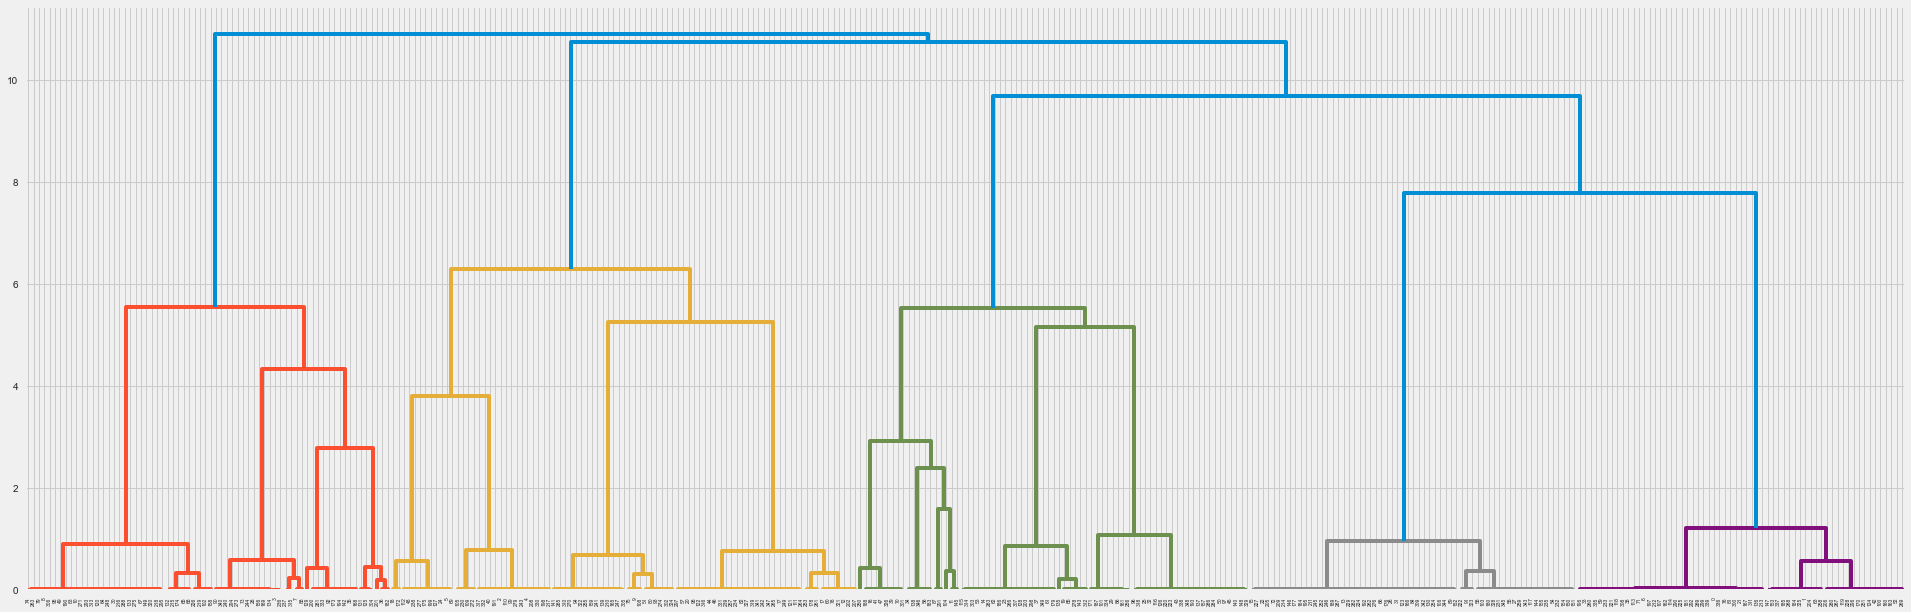

In [90]:
plt.figure(figsize=(30,10))
z = sch.linkage(pca_data[:350,:], "ward")
sch.dendrogram(z);

In [91]:
PCA_kmeans = KMeans(n_clusters=5, **kmeans_set)
PCA_kmeans.fit(pca_data)
# create a dataframe for the pca data
pca_df = pd.DataFrame(pca_data, columns=["PC1","PC2","PC3","PC4"])
pca_df["label"] = PCA_kmeans.labels_
pca_df.head()

,PC1,PC2,PC3,PC4,label
0,0.451097,-0.230365,-0.538529,-0.026857,1
1,0.456187,-0.289883,-0.662871,-0.305140,1
2,0.042831,0.410520,0.998763,-0.178936,4
3,-0.836264,0.692529,0.036349,0.290451,2
4,0.043075,0.408752,0.998431,-0.175443,4


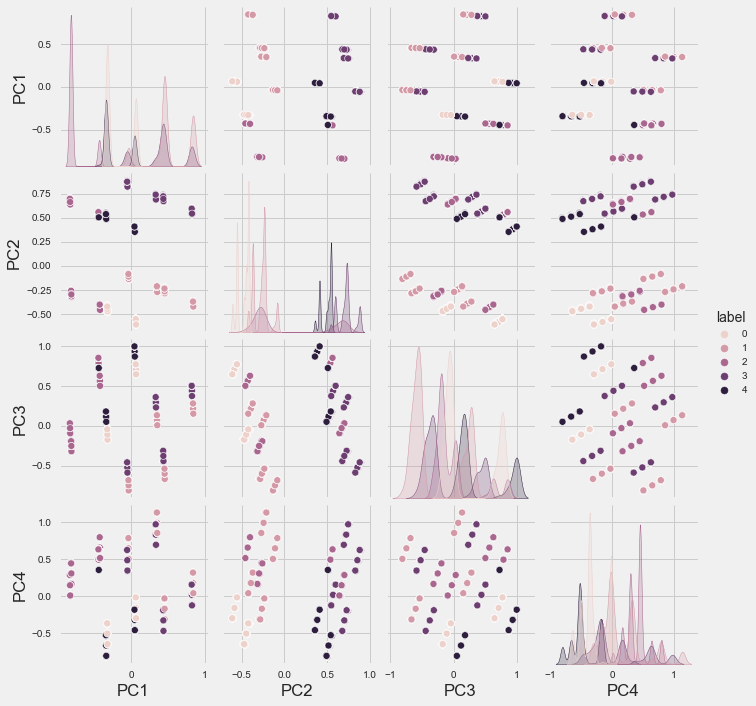

In [92]:
sns.pairplot(pca_df,hue="label")

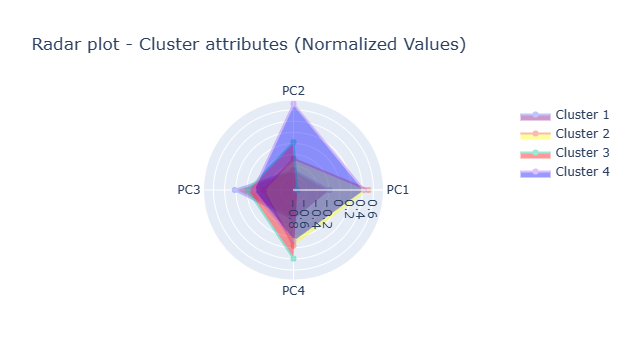

In [93]:
attributes = pca_df.columns[:4]
colors=["purple","yellow","red","blue"]
cluster=["Cluster 1","Cluster 2","Cluster 3","Cluster 4"]

fig=go.Figure()
for index in range(0,4):
    fig.add_trace(go.Scatterpolar(r=np.mean(pca_df.loc[pca_df.label==index,attributes]),
                                 theta=attributes,
                                 fill="toself",
                                 fillcolor=colors[index],
                                 opacity=0.4,
                                 name=cluster[index]))
    
fig.update_layout(polar=dict(radialaxis=dict(visible=True)),
                 showlegend=True,
                 title="Radar plot - Cluster attributes (Normalized Values)")
fig.show()